# 네이버 영화리뷰 감성분석하기

## 1. 데이터 준비와 확인

In [1]:
# 모듈 불러오기

import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant
 

In [2]:
# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


label값을 보면 부정적인 내용의 라벨은 0, 긍정적인 내용의 라벨은 1이다.

---

## 2. 데이터로더 구성

In [3]:
tokenizer = Mecab() # 형태소 분석기 mecab 사용
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# load_data 함수 정의
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # train 데이터의 중복 제거
    train_data = train_data.dropna(how = 'any') # train 데이터의 NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # test 데이터의 중복 제거
    test_data = test_data.dropna(how = 'any') # test 데이터의 NaN 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 한국어 토크나이저로 토큰화 (morphs : 형태소 추출)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 한국어 토크나이저로 토큰화 (morphs : 형태소 추출)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 사전 word_to_index {단어:인덱스} 구성
    words = np.concatenate(X_train).tolist() # 토큰화시킨 단어들을 모두 한 리스트에 몰아넣음
    counter = Counter(words) # 각 단어의 개수 카운팅해서 정렬
    counter = counter.most_common(10000-4) # 가장 개수가 많은 단어들 순서대로 (10000-4)개 리턴
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # 특수 토큰 4개 추가
    word_to_index = {word:index for index, word in enumerate(vocab)} # {단어:인덱스}형태로 사전 구성
        
    # 리뷰 텍스트를 사전의 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
# 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [6]:
# 사전 index_to_word {인덱스:단어} 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
for i in range(10):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
.
영화
다
고
하
을


In [8]:
print(word_to_index['영화'])
print(word_to_index['재미'])
print(word_to_index['감동'])

5
94
80


In [9]:
# 문장 인코딩과 디코딩 함수 정의

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
# 데이터 예시 확인

print(X_train[0]) # 1번째 리뷰데이터
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨:', y_train[0]) # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨: 0


---

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [11]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차 계산
print("문장길이 평균 : ", np.mean(num_tokens))
print("문장길이 최대 : ", np.max(num_tokens))
print("문장길이 표준편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens<max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [12]:
# padding으로 문장 길이 통일

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

print(X_train.shape)

(146182, 41)


padding을 pre에 채우는 이유 : RNN은 입력데이터가 순차적으로 처리되므로 가장 마지막 입력이 최종 state값에 영향을 많이 미치게 된다. 그래서 padding이 post에 채워진다면 굉장히 비효율적인 상황이 발생하게 된다. 거의 10% 차이라고 한다.

In [13]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]


#### validation set 구성

훈련 데이터의 약 15%인 20000건을 분리하여 validation set으로 사용해보자.

In [14]:
# validation set 20000건 분리
X_val = X_train[:20000]
y_val = y_train[:20000]

# validation set을 제외한 나머지 126182건
partial_X_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


---

## 4. 모델 구성, 훈련, 평가, 시각화하기

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

### 1) LSTM

#### 모델 구성

In [16]:
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수는 8 (변경 가능)
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련 개시

In [17]:
lstm.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

epochs=10 # 훈련결과 보고 바꿔보기

history_lstm = lstm.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val), 
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 8ms/step - loss: 0.4457 - accuracy: 0.8049 - val_loss: 0.3482 - val_accuracy: 0.8497
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3219 - accuracy: 0.8644 - val_loss: 0.3372 - val_accuracy: 0.8536
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2904 - accuracy: 0.8776 - val_loss: 0.3395 - val_accuracy: 0.8557
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2666 - accuracy: 0.8886 - val_loss: 0.3461 - val_accuracy: 0.8565
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2450 - accuracy: 0.8988 - val_loss: 0.3535 - val_accuracy: 0.8562
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2252 - accuracy: 0.9079 - val_loss: 0.3676 - val_accuracy: 0.8555
Epoch 7/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2058 - accuracy: 0.9163 - val_loss: 0.3869 - val_accuracy: 0.8547
Epoch 

#### 모델 평가

In [18]:
# 테스트셋으로 평가

lstm_results = lstm.evaluate(X_test, y_test, verbose=2)

print(lstm_results)

1537/1537 - 3s - loss: 0.4596 - accuracy: 0.8460
[0.45956042408943176, 0.8460035920143127]


#### Loss, Accuracy 그래프 시각화

.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다.

In [19]:
history_lstm_dict = history_lstm.history
print(history_lstm_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

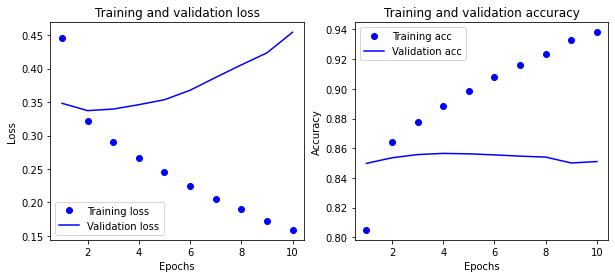

In [21]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2) 1-D CNN

#### 모델 구성

In [22]:
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(8, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 모델 훈련 개시

In [23]:
cnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

epochs=10 # 훈련결과 보고 바꿔보기

history_cnn = cnn.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val), 
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 4s 7ms/step - loss: 0.4456 - accuracy: 0.7869 - val_loss: 0.3427 - val_accuracy: 0.8507
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3060 - accuracy: 0.8714 - val_loss: 0.3316 - val_accuracy: 0.8556
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2552 - accuracy: 0.8980 - val_loss: 0.3374 - val_accuracy: 0.8574
Epoch 4/10
247/247 [==============================] - 1s 6ms/step - loss: 0.1945 - accuracy: 0.9268 - val_loss: 0.3666 - val_accuracy: 0.8521
Epoch 5/10
247/247 [==============================] - 1s 6ms/step - loss: 0.1324 - accuracy: 0.9540 - val_loss: 0.4518 - val_accuracy: 0.8443
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.0874 - accuracy: 0.9712 - val_loss: 0.5097 - val_accuracy: 0.8434
Epoch 7/10
247/247 [==============================] - 1s 6ms/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.6396 - val_accuracy: 0.8352
Epoch 

#### 모델 평가

In [24]:
cnn_results = cnn.evaluate(X_test, y_test, verbose=2)

print(cnn_results)

1537/1537 - 3s - loss: 0.8758 - accuracy: 0.8321
[0.8757665157318115, 0.8321093916893005]


#### Loss, Accuracy 그래프 시각화

In [25]:
history_cnn_dict = history_cnn.history
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

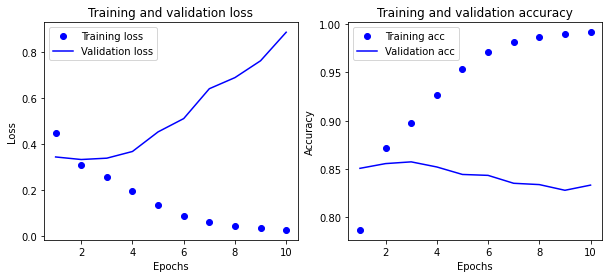

In [26]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3) GlobalMaxPooling1D

#### 모델 구성

In [27]:
maxpooling = tf.keras.Sequential()
maxpooling.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxpooling.add(tf.keras.layers.GlobalMaxPooling1D())
maxpooling.add(tf.keras.layers.Dense(8, activation='relu'))
maxpooling.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

maxpooling.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련 개시

In [28]:
maxpooling.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

epochs=10 # 훈련결과 보고 바꿔보기

history_maxpooling = maxpooling.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val), 
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 5ms/step - loss: 0.4762 - accuracy: 0.7973 - val_loss: 0.3482 - val_accuracy: 0.8487
Epoch 2/10
247/247 [==============================] - 1s 4ms/step - loss: 0.3149 - accuracy: 0.8677 - val_loss: 0.3321 - val_accuracy: 0.8561
Epoch 3/10
247/247 [==============================] - 1s 4ms/step - loss: 0.2686 - accuracy: 0.8907 - val_loss: 0.3371 - val_accuracy: 0.8561
Epoch 4/10
247/247 [==============================] - 1s 4ms/step - loss: 0.2296 - accuracy: 0.9101 - val_loss: 0.3488 - val_accuracy: 0.8555
Epoch 5/10
247/247 [==============================] - 1s 4ms/step - loss: 0.1905 - accuracy: 0.9296 - val_loss: 0.3664 - val_accuracy: 0.8555
Epoch 6/10
247/247 [==============================] - 1s 4ms/step - loss: 0.1514 - accuracy: 0.9477 - val_loss: 0.3949 - val_accuracy: 0.8529
Epoch 7/10
247/247 [==============================] - 1s 4ms/step - loss: 0.1152 - accuracy: 0.9643 - val_loss: 0.4278 - val_accuracy: 0.8487
Epoch 

#### 모델 평가

In [29]:
maxpooling_results = maxpooling.evaluate(X_test, y_test, verbose=2)

print(maxpooling_results)

1537/1537 - 2s - loss: 0.5450 - accuracy: 0.8391
[0.5449765920639038, 0.8390870094299316]


#### Loss, Accuracy 그래프 시각화

In [30]:
history_maxpooling_dict = history_maxpooling.history
acc = history_maxpooling_dict['accuracy']
val_acc = history_maxpooling_dict['val_accuracy']
loss = history_maxpooling_dict['loss']
val_loss = history_maxpooling_dict['val_loss']

epochs = range(1, len(acc) + 1)

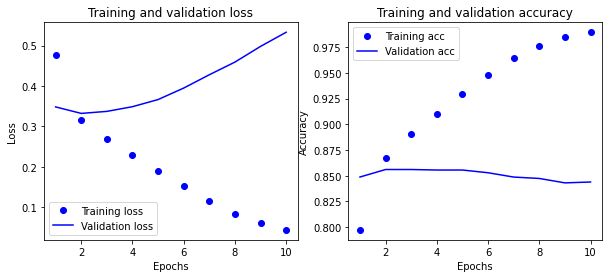

In [31]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3가지 모델 비교분석

In [32]:
print(lstm_results)
print(cnn_results)
print(maxpooling_results)

[0.45956042408943176, 0.8460035920143127]
[0.8757665157318115, 0.8321093916893005]
[0.5449765920639038, 0.8390870094299316]


세 모델 다 loss와 accuracy가 비슷비슷하다.<br>
그나마 LSTM이 loss가 적고 accuracy가 높아서 성능이 셋 중에는 제일 나은 듯 싶다.<br>
이상한건 세 모델 다 Epoch가 2가 넘어가면서 과적합이 심하게 발생하는 것 같다.<br>
앞에서 지정한 파라미터들 중에 무언가가 잘못돼서 그런것 같은데, 어떤것 때문에 그런지는 잘모르겠다.<br> 다음에 시간이 나면 vocab_size, word_vector_dim, batch_size 조절해봐야겠다.

---

## 5. 학습된 Embedding 레이어 분석

### 1) LSTM

In [33]:
# Embedding Layer에 학습된 워드벡터 확인

embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]
print(weights_lstm.shape)     # shape: (vocab_size, embedding_dim)

(10000, 200)


In [34]:
# 학습한 Embedding 파라미터를 파일에 써서 저장

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
# 위에 남긴 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용 가능

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.05015786,  0.00094248,  0.06575499,  0.13497485, -0.00915421,
       -0.05510092,  0.02841054, -0.03168005, -0.07602143, -0.07774016,
        0.06825794,  0.23027916, -0.01075279, -0.0528102 , -0.18260764,
        0.05336111, -0.04668898, -0.01173187,  0.15238772,  0.06763704,
       -0.08083709, -0.0716208 ,  0.03290325,  0.00659671, -0.04382437,
       -0.1020693 , -0.05684714,  0.07705168, -0.03612543,  0.0650054 ,
       -0.33166242,  0.04166878, -0.06850883, -0.0391513 ,  0.01925269,
        0.08648683,  0.00976418, -0.17287706, -0.04769906,  0.05584907,
       -0.05134274,  0.11271007, -0.025289  ,  0.00356117, -0.00686468,
       -0.01501556,  0.36770383, -0.10834166,  0.1042545 ,  0.13065396,
       -0.07427921, -0.16770728, -0.17991844,  0.05033917,  0.05699811,
       -0.1018577 ,  0.02426533, -0.01906898,  0.03734383,  0.00068757,
        0.03302326, -0.01386817,  0.07963765, -0.14150068,  0.0230231 ,
       -0.16375417,  0.02597933, -0.00340135,  0.21003444, -0.00

워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있다. gensim을 사용하면 아래와 같이 해볼 수 있다.

In [36]:
word_vectors.similar_by_word("최고")

[('굿', 0.8884930610656738),
 ('명품', 0.8680484294891357),
 ('통쾌', 0.8632184863090515),
 ('명작', 0.8526573181152344),
 ('진한', 0.8521097302436829),
 ('굳', 0.8505361080169678),
 ('재밌', 0.8490205407142639),
 ('졸이', 0.8486909866333008),
 ('완벽', 0.8441454172134399),
 ('꿀', 0.841754674911499)]

### 2) 1-D CNN

In [37]:
embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
# 단어 유사도 확인

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
word_vectors.similar_by_word("최고")

[('돌이켜', 0.7458280920982361),
 ('두려워', 0.7312971949577332),
 ('-)', 0.7297272682189941),
 ('냉혹', 0.7217221260070801),
 ('테드', 0.7201335430145264),
 ('따스', 0.7180869579315186),
 ('노홍철', 0.7156553268432617),
 ('사악', 0.7134921550750732),
 ('올려야', 0.7097048163414001),
 ('개꿀', 0.7092106342315674)]

### 3) MaxPooling1D

In [39]:
embedding_maxpooling = maxpooling.layers[0]
weights_maxpooling = embedding_maxpooling.get_weights()[0]

word2vec_file_path_maxpooling = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_maxpooling.txt'
f = open(word2vec_file_path_maxpooling, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = maxpooling.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
# 단어 유사도 확인

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_maxpooling, binary=False)
word_vectors.similar_by_word("최고")

[('니당', 0.3364609479904175),
 ('러셀', 0.2947235703468323),
 ('손꼽', 0.29089629650115967),
 ('기승전결', 0.2826807200908661),
 ('퀸', 0.27578645944595337),
 ('서동요', 0.2749508023262024),
 ('배울', 0.27093011140823364),
 ('best', 0.2591332197189331),
 ('시대', 0.25608211755752563),
 ('올라갈', 0.25582483410835266)]

세 모델의 임베딩 레이어들에 대해 단어 유사도를 살펴봤을 때, 역시 LSTM을 통해 뽑아낸 단어들의 유사도가 거의 다 80%대로 가장 높았다. '최고'라는 단어와 유사한 단어들을 살펴봤을 때는 '굿', '명품', '통쾌', '명작', '재밌', '굳', '완벽' 등 엄청 긍정적인 단어들이 많이 나왔다. 그렇지만 엄밀히 따져봤을 때 '최고'와 연결시킬 수 있는 단어들이 나온 것이지, 실제로 성질이 비슷한 단어들은 나오지 않았다고 볼 수 있다.<br>
CNN을 통해 봤을 때는 전체적으로 유사도가 70%이긴 한데 단어들을 확인해보니 전혀 '최고'와 어울리지 않은 단어들이 많이 나왔다. LSTM보다는 확실히 성능이 떨어진다.<br>
MaxPooling1D는 'best'라는 거의 완벽하게 유사한 단어가 딱 하나 나왔지만, 전체적으로는 20%대의 유사도가 나오고 다른 단어들을 봤을 때는 연관성도 낮다.

---

## 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [41]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [42]:
wordexample = word2vec.similar_by_word("최고")
wordexample

/tmp/ipykernel_6158/23970215.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  wordexample = word2vec.similar_by_word("최고")


[('최대', 0.5721614360809326),
 ('최강', 0.5064552426338196),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037323236465454),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.44647401571273804),
 ('최초', 0.44505739212036133),
 ('최상', 0.4345606565475464)]

In [43]:
# 이전의 모델들의 임베딩 레이어를 Word2Vec의 것으로 교체해서 다시 학습

vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_6158/3653037712.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6158/3653037712.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


이제 각 모델에 다시 적용해보자.

### 1) LSTM

In [44]:
lstmk = keras.Sequential()
lstmk.add(keras.layers.Embedding(vocab_size, 
                                word_vector_dim, 
                                embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                input_length=maxlen, 
                                trainable=True))   # trainable을 True로 주면 Fine-tuning
lstmk.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수는 8 (변경 가능)
lstmk.add(keras.layers.Dense(8, activation='relu'))
lstmk.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

lstmk.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstmk.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history_lstmk = lstmk.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 3s 8ms/step - loss: 0.5193 - accuracy: 0.7344 - val_loss: 0.3952 - val_accuracy: 0.8235
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3621 - accuracy: 0.8437 - val_loss: 0.3565 - val_accuracy: 0.8432
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3221 - accuracy: 0.8659 - val_loss: 0.3450 - val_accuracy: 0.8522
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2998 - accuracy: 0.8761 - val_loss: 0.3457 - val_accuracy: 0.8512
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2840 - accuracy: 0.8836 - val_loss: 0.3444 - val_accuracy: 0.8540
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2702 - accuracy: 0.8911 - val_loss: 0.3498 - val_accuracy: 0.8534
Epoch 7/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2584 - accuracy: 0.8965 - val_loss: 0.3508 - val_accuracy: 0.8536
Epoch 

In [46]:
lstmk_results = lstmk.evaluate(X_test,  y_test, verbose=2)

print(lstmk_results)

1537/1537 - 3s - loss: 0.3777 - accuracy: 0.8483
[0.3776867389678955, 0.8483430743217468]


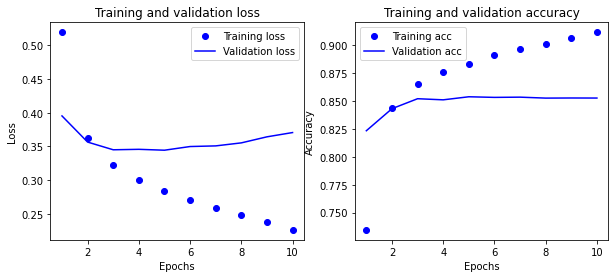

In [47]:
history_lstmk_dict = history_lstmk.history

acc = history_lstmk_dict['accuracy']
val_acc = history_lstmk_dict['val_accuracy']
loss = history_lstmk_dict['loss']
val_loss = history_lstmk_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2) 1-D CNN

In [48]:
cnnk = keras.Sequential()
cnnk.add(keras.layers.Embedding(vocab_size,
                               word_vector_dim,
                               embeddings_initializer=Constant(embedding_matrix), 
                               input_length=maxlen, 
                               trainable=True))
cnnk.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnnk.add(keras.layers.MaxPooling1D(5))
cnnk.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnnk.add(keras.layers.GlobalMaxPooling1D())
cnnk.add(keras.layers.Dense(8, activation='relu'))
cnnk.add(keras.layers.Dense(1, activation='sigmoid'))

cnnk.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [49]:
cnnk.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history_cnnk = cnnk.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 7ms/step - loss: 0.5257 - accuracy: 0.7313 - val_loss: 0.4312 - val_accuracy: 0.8012
Epoch 2/10
247/247 [==============================] - 1s 6ms/step - loss: 0.3833 - accuracy: 0.8296 - val_loss: 0.3742 - val_accuracy: 0.8347
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3285 - accuracy: 0.8594 - val_loss: 0.3549 - val_accuracy: 0.8443
Epoch 4/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2912 - accuracy: 0.8785 - val_loss: 0.3539 - val_accuracy: 0.8459
Epoch 5/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2660 - accuracy: 0.8911 - val_loss: 0.3723 - val_accuracy: 0.8427
Epoch 6/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2422 - accuracy: 0.9029 - val_loss: 0.3661 - val_accuracy: 0.8475
Epoch 7/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2197 - accuracy: 0.9138 - val_loss: 0.3857 - val_accuracy: 0.8442
Epoch 

In [50]:
cnnk_results = cnnk.evaluate(X_test,  y_test, verbose=2)

print(cnnk_results)

1537/1537 - 2s - loss: 0.4791 - accuracy: 0.8369
[0.4790605902671814, 0.8369103074073792]


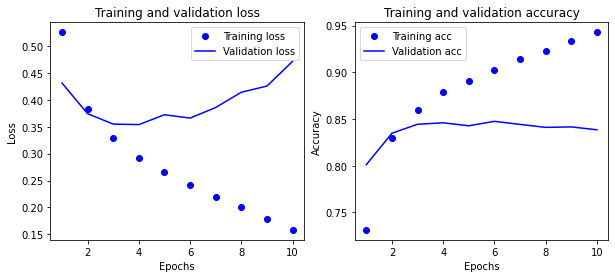

In [51]:
history_cnnk_dict = history_cnnk.history

acc = history_cnnk_dict['accuracy']
val_acc = history_cnnk_dict['val_accuracy']
loss = history_cnnk_dict['loss']
val_loss = history_cnnk_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3) MaxPooling1D

In [52]:
maxpoolingk = tf.keras.Sequential()
maxpoolingk.add(tf.keras.layers.Embedding(vocab_size, 
                                          word_vector_dim, 
                                          embeddings_initializer=Constant(embedding_matrix),  
                                          input_length=maxlen, 
                                          trainable=True))
maxpoolingk.add(tf.keras.layers.GlobalMaxPooling1D())
maxpoolingk.add(tf.keras.layers.Dense(8, activation='relu'))
maxpoolingk.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

maxpoolingk.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [53]:
maxpoolingk.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history_maxpoolingk = maxpoolingk.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 5ms/step - loss: 0.7242 - accuracy: 0.5340 - val_loss: 0.6696 - val_accuracy: 0.5996
Epoch 2/10
247/247 [==============================] - 1s 4ms/step - loss: 0.6144 - accuracy: 0.6629 - val_loss: 0.5569 - val_accuracy: 0.7158
Epoch 3/10
247/247 [==============================] - 1s 4ms/step - loss: 0.5188 - accuracy: 0.7437 - val_loss: 0.5020 - val_accuracy: 0.7534
Epoch 4/10
247/247 [==============================] - 1s 4ms/step - loss: 0.4695 - accuracy: 0.7766 - val_loss: 0.4724 - val_accuracy: 0.7742
Epoch 5/10
247/247 [==============================] - 1s 4ms/step - loss: 0.4351 - accuracy: 0.7981 - val_loss: 0.4461 - val_accuracy: 0.7894
Epoch 6/10
247/247 [==============================] - 1s 4ms/step - loss: 0.4094 - accuracy: 0.8141 - val_loss: 0.4395 - val_accuracy: 0.7947
Epoch 7/10
247/247 [==============================] - 1s 4ms/step - loss: 0.3887 - accuracy: 0.8265 - val_loss: 0.4188 - val_accuracy: 0.8072
Epoch 

In [54]:
maxpoolingk_results = maxpoolingk.evaluate(X_test,  y_test, verbose=2)

print(maxpoolingk_results)

1537/1537 - 2s - loss: 0.4076 - accuracy: 0.8150
[0.4075576663017273, 0.815021276473999]


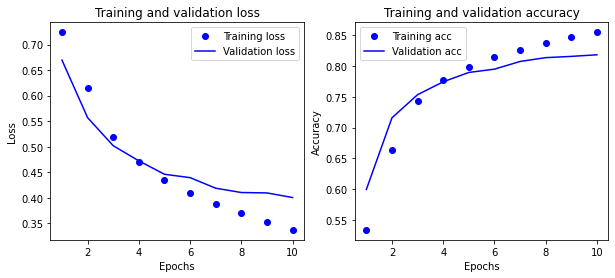

In [55]:
history_maxpoolingk_dict = history_maxpoolingk.history

acc = history_maxpoolingk_dict['accuracy']
val_acc = history_maxpoolingk_dict['val_accuracy']
loss = history_maxpoolingk_dict['loss']
val_loss = history_maxpoolingk_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

세 모델 다시 비교해보자.

In [56]:
print(lstmk_results)
print(cnnk_results)
print(maxpoolingk_results)

[0.3776867389678955, 0.8483430743217468]
[0.4790605902671814, 0.8369103074073792]
[0.4075576663017273, 0.815021276473999]


accuracy가 더 안좋아졌다. 아무래도 시각화해서 보니 과적합때문에 그런것 같아서 계속해서 제일 성능이 좋은 LSTM의 에포크 수를 줄여서 다시해봐야겠다. 그리고 batch_size도 줄여봐야겠다. optimizer 종류도 바꿔봐야겠다.

#### optimizer, epochs, batch_size 변경 후 LSTM으로 다시 시도 (결국은 validation set 다시 분배 후 성공)

In [57]:
lstmk.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8

history_lstmk = lstmk.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
1972/1972 [==============================] - 13s 6ms/step - loss: 0.2400 - accuracy: 0.9045 - val_loss: 0.3502 - val_accuracy: 0.8556
Epoch 2/8
1972/1972 [==============================] - 11s 6ms/step - loss: 0.2429 - accuracy: 0.9031 - val_loss: 0.3534 - val_accuracy: 0.8540
Epoch 3/8
1972/1972 [==============================] - 11s 5ms/step - loss: 0.2439 - accuracy: 0.9034 - val_loss: 0.3440 - val_accuracy: 0.8548
Epoch 4/8
1972/1972 [==============================] - 11s 6ms/step - loss: 0.2439 - accuracy: 0.9030 - val_loss: 0.3415 - val_accuracy: 0.8582
Epoch 5/8
1972/1972 [==============================] - 11s 5ms/step - loss: 0.2428 - accuracy: 0.9035 - val_loss: 0.3494 - val_accuracy: 0.8564
Epoch 6/8
1972/1972 [==============================] - 11s 5ms/step - loss: 0.2413 - accuracy: 0.9045 - val_loss: 0.3553 - val_accuracy: 0.8534
Epoch 7/8
1972/1972 [==============================] - 11s 5ms/step - loss: 0.2398 - accuracy: 0.9051 - val_loss: 0.3526 - val_accuracy:

In [59]:
lstmk_results = lstmk.evaluate(X_test,  y_test, verbose=2)

print(lstmk_results)

1537/1537 - 3s - loss: 0.3535 - accuracy: 0.8531
[0.353481650352478, 0.853123664855957]


## 회고

- 여러 시도를 해봤는데 accuracy가 85%를 넘지 못해서 너무 힘들었다. 처음에는 단순하게 epoch 수를 줄이고, batch_size를 줄이는 방식으로만 계속 해봤다. 여러 파라미터들을 바꿔가면서 계속 돌려봤는데 계속 84% 언저리에서만 왔다갔다했다.
- 정말 열심히 발버둥쳤는데 안나와서 구글링하던 중, 데이터에서 정규표현식을 통해 한글이 아닌 것들이나 특수문자를 제거해보기로 했다. 그렇게 해서 load_data 함수의 train data와 test data에서 열심히 특수문자를 공백으로 바꾸고 지워줬는데, LSTM 모델까지 잘되다가 CNN 모델에서 에러가 났다. 당연한 것이었고 바보같았지만 그때 정규표현식이 RNN에서만 써야한다는 것을 깨달았다. RNN은 시퀀스 데이터를 하나하나씩 훑는 느낌이고 CNN은 필터 단위로 처리돼서 이미지 분류에서 많이 쓰니깐.<br>
- 정규표현식 썼던 것을 다시 지우고, 고민하던 차에 optimizer를 바꿔봐야겠다는 생각이 들었다. 그래서 LSTM에서 쓸 수 있는 optimizer를 찾아보다가 SGD, rmsprop이 추가로 있는 것을 보고 넣어봤는데도 85%를 넘지 못했다.
- 고민하다가, 혹시 데이터셋이 적어서 그런건가라는 생각이 들었다. 근데 한정된 데이터셋을 받아온 것이기 때문에 데이터양을 더 늘릴 수는 없고, 쭉 보다가 내가 validation set를 너무 많이 설정한 것이 아닌가라는 생각이 들었다. 처음에는 훈련데이터의 30%인 40000을 지정했는데, 그것을 반으로 줄였다. 그렇게 해서 하이퍼파라미터도 바꿔보고 돌려보니깐 85%를 겨우 넘겼다.

- 이번에 load_data 함수를 혼자서 써보고 싶었는데 아예 엄두가 나질 않았다. 이런 코드를 혼자서 생각해내기 위해서는 정말 지겹도록 말하는 것이지만 꾸준한 공부와 자꾸 혼자서 코드를 지어보려는 노력이 필요하다는 것이다. 시간이 없다는 핑계로 잘 안되는데, 언젠가는 꼭 저런 코드를 통해 함수를 혼자서 써보는 능력을 기르고 싶다. (특수 토큰 4개 앞에 붙여주는 것 꼭 복습!!)
- 똑같은 데이터로 padding을 pre에 붙이는 것과 post에 붙이는 것 둘의 차이가 얼마나 나는지 실험해보고 싶었는데, 이 노드를 완성하는데에 너무 오래걸렸고, 85%에 집착하다보니깐 일단 점수부터 내고보자는 생각 때문에 그런 실험을 못했다. 다음에 다시 이 노드를 복습할 때 꼭 해봐야겠다.
- gensim에서 계속 오류가 났는데, 다운그레이드를 시켜줘야 한국어 word2vec이 제대로 작동할 수 있었다. 버전이 바뀌면서 메소드와 인자들을 쓰는 방법이 바뀐다는 것을 알았다. 구글링과 버전의 중요성을 실감할 수 있었다.
- 자연어 처리는 지난번에도 느낀 것이지만, 굉장히 재미있는 작업이고 흥미로운 지점이 상당히 많다. 모델이 학습을 해서 유사한 단어를 찾는 과정이 진짜 재밌다. 근데 재밌으면서도 너무 어렵다. 까다로운 부분이 많고, 신경써야 할 부분이 많고, 그래서 더욱 응용을 하기가 힘들다. 다양한 모델을 써본다는 것에 의의를 두고싶다.
- 자꾸 이것저것 시도해보고 실패하다보니 노드가 많이 밀렸다. 파이썬에서 부족한 부분이 너무 많은데 그 공부는 언제할 수 있을까?